# Neural Network from Scratch

Notebook will be used to construct a neural network from scratch -- will be helpful in showing different components and steps to creating a neural net. 

We will not be using any pre-built architectures, optimizers, or data loading frameworks.

[source 1](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch)

## Download Data from Kaggle

In [2]:
# install dependencies
import os
from pathlib import Path

In [3]:
# determine if we are running in a kaggle notebook
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: 
    path = Path('../input/titanic')
else: 
    path = Path('titanic')
    if not path.exists():
        import zipfile, kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

Data from Kaggle competitions always lives in the `../input` folder

## Import Necessary Libraries and Set Display Settings

In [4]:
import torch
import pandas as pd, numpy as np 
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Clean Data

We are working with the titanic dataset. Data is provided in a tabular format in the form of a CSV

In [5]:
# read data into pandas dataframe
df = pd.read_csv(path/'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To build our neural network, we will want to multiply each column by some coefficients. First, to ensure no errors, we need to handle missing values. 

#### Missing Values

In [6]:
# check for missing values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
# replace missing values with the most common value -- the "mode"
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [8]:
# fill missing values with the modes 
df.fillna(modes, inplace=True)

In [9]:
# confirm no more missing values
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

#### Summary Statistics of Numeric Columns

In [10]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


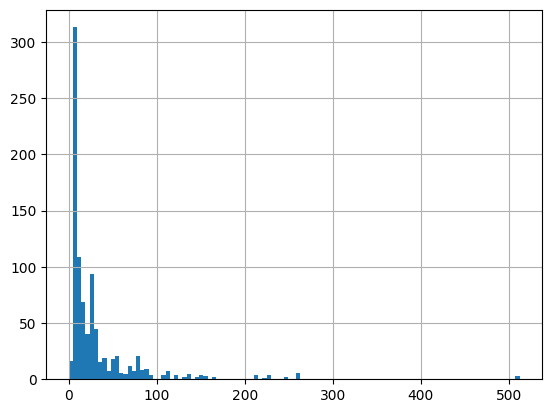

In [11]:
# preview histogram of fare
df['Fare'].hist(bins='auto');

We have some significant skew here -- the most common approach to address this will be to take the logarithm. 

Need to note that there are zeros in the `Fare` column, and `log(0)` is infinite -- to fix this, we'll simply add `1` to all values first:

In [12]:
df['LogFare'] = np.log(df['Fare'] + 1)

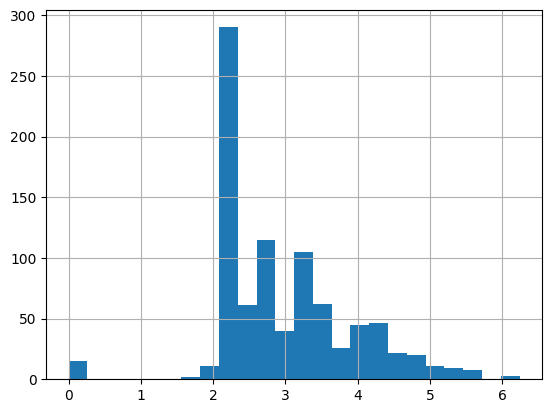

In [13]:
# reprint histogram
df['LogFare'].hist(bins='auto');

#### Confirm `Pclass` contains just 3 values

In [14]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [15]:
# summary of all non-numeric columns 
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


#### Handle Categorical Columns

In [16]:
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [17]:
# preview new columns
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2',
              'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


#### Setup Independent and Dependent Variables

In [18]:
from torch import tensor 

# specify dependent variable
t_dep = tensor(df['Survived'])

# specify independent columns 
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = tensor(df[indep_cols].values, dtype=torch.float)

In [19]:
# preview target   
print(t_dep.shape)

torch.Size([891])


In [20]:
# preview predictors
print(t_indep.shape)

torch.Size([891, 12])


We can see we have 891 rows, and 12 columns in our tensor

## Construct Linear Model

Our first model will be a simple linear model -- we'll need a coefficient for each column in `t_inep`. We'll pick numbers in the range `(-0.5, 0.5)`, and set our manual seed for reproducibility.

In [21]:
# set seed
torch.manual_seed(442)

In [22]:
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff) - 0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

Predictions will be calculated by multiplying each row by the coefficients, and adding them up. 

We don't need a separate constant term ("intercept" term), or a column of all `1s` to give the same effect as having a constant term. This is because our dummy variables already cover the entire dataset -- e.g. there's a column for "male" and a column for "female", and everyone in the dataset is exatly one of these; therefore, we don't need a separate intercept term to cover rows that aren't otherwise part of a column.

In [23]:
# multiply each row by coefficients
t_indep * coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

We have an issue of scale here -- age is dominating the other columns. We will restrict each independent variable to be between the value of 0 and 1, by dividing each column by its max

In [24]:
vals, indices = t_indep.max(dim=0)
t_indep = t_indep / vals # this is dividing a matrix by a vector (broadcasting)

In [25]:
# run multiplication again and evaluate 
t_indep * coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

The first column is no longer dominating

#### Create Predictions

In [26]:
preds = (t_indep * coeffs).sum(axis=1)

Our predictions are calculated by adding up the rows of the product.

In [27]:
# preview the first few predictions
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

These are not going to be much use to use because we are on our first loop of the process, and we started with random coefficients. 

To perform gradient descent, we need a loss function. Taking the average error of the rows (i.e. the absolute value of the difference between the prediction and the dependent) is generally a reasonable approach:

In [28]:
loss = torch.abs(preds-t_dep).mean()

In [29]:
# preview loss
loss

tensor(0.5382)

## Create Functions for Steps Above

In [30]:
def calc_preds(coeffs, indeps): 
    return (indeps*coeffs).sum(axis=1)

def calc_loss(coeffs, indeps, deps):
    return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Gradient Descent Step

We are going to do a single "epoch" of gradient descent manually. The only thing we're going to automate is calculating gradients. 

To get PyTorch to calculate gradients, we'll need to call `requires_grad_()` on our `coeffs`

In [31]:
# track gradients
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [32]:
# calc loss, now that gradients are tracked
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

In [33]:
# calculate gradients
loss.backward()

# view gradients
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

Each time we call `backward`, the gradients are actually added to whatever is in the `.grad` attribute 

In [34]:
# Re-run steps above to show that gradients are added
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.0212,  0.0258, -0.0082, -0.0969,  0.4198, -0.4265, -0.2424, -0.0494,  0.2851, -0.3771, -0.0382,  0.4085])

Because gradients are summed, we need to set them back to zero after we do a gradient descent step.

#### One Gradient Descent Step

In [35]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.4945)


In PyTorch, any method that ends in `_` changes its object in-place.
`a.zero_()` sets all elements of a tensor to zero.

## Training Linear Model

Before training, we need to hold out a set for validation.

In [41]:
# Use Random Splitter to get indices that will split data
from fastai.data.transforms import RandomSplitter
trn_split, val_split = RandomSplitter(seed=42)(df)

In [42]:
# split variables into train and validation
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_indep), len(val_indep)

(713, 178)

## Create Functions for Above

In [43]:
def update_coeffs(coeffs, learning_rate):
    coeffs.sub_(coeffs.grad*learning_rate)
    coeffs.grad.zero_()

In [44]:
def one_epoch(coeffs, learning_rate):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, learning_rate)
    print(f'{loss:.3f}', end='; ')

In [45]:
def init_coeffs():
    return (torch.rand(n_coeff)-0.5).requires_grad_()

## Use Functions to Train Linear Model

In [46]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): 
        one_epoch(coeffs, lr)
    return coeffs

In [47]:
# run function
coeffs = train_model(18, lr=0.2)

0.536; 0.502; 0.477; 0.454; 0.431; 0.409; 0.388; 0.367; 0.349; 0.336; 0.330; 0.326; 0.329; 0.304; 0.314; 0.296; 0.300; 0.289; 

We print loss at each step, so it makes sense that we should see it decrease.

In [48]:
# show coefficients for each column with col label
def show_coeffs(): 
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))

show_coeffs()

{'Age': tensor(-0.2694),
 'SibSp': tensor(0.0901),
 'Parch': tensor(0.2359),
 'LogFare': tensor(0.0280),
 'Sex_male': tensor(-0.3990),
 'Sex_female': tensor(0.2345),
 'Pclass_1': tensor(0.7232),
 'Pclass_2': tensor(0.4112),
 'Pclass_3': tensor(0.3601),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2395),
 'Embarked_S': tensor(0.2122)}

## Measuring Accuracy

The Kaggle competition is not scored by absolute error, but is instead scored by accuracy. So we will need to calculate accuracy. 

In [49]:
preds = calc_preds(coeffs, val_indep)

We will assume that any passenger with a score of over 0.5 is predicted to survive. 

In [51]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [52]:
# print average accuracy
results.float().mean()

tensor(0.7865)

In [53]:
# put accuracy into function
def acc(coeffs):
    return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()

acc(coeffs)

tensor(0.7865)

#### Using Sigmoid

Looking at some of our predictions, we can see that some are >1 and <0

In [56]:
preds[:30]

tensor([ 0.8160,  0.1295, -0.0148,  0.1831,  0.1520,  0.1350,  0.7279,  0.7754,  0.3222,  0.6740,  0.0753,  0.0389,  0.2216,  0.7631,
         0.0678,  0.3997,  0.3324,  0.8278,  0.1078,  0.7126,  0.1023,  0.3627,  0.9937,  0.8050,  0.1153,  0.1455,  0.8652,  0.3425,
         0.1262,  0.7630])

To fix this, we should pass every prediction through the sigmoid function, which has a minimum at 0 and maximum at 1

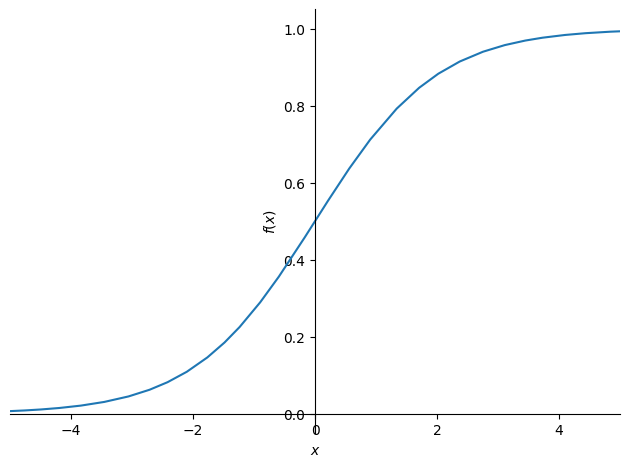

In [59]:
import sympy
sympy.plot('1/(1+exp(-x))', xlim=(-5,5))

#### Modify calc_preds to use Sigmoid

In [60]:
def calc_preds(coeffs, indeps): 
    return torch.sigmoid((indeps*coeffs).sum(axis=1))

#### Train New Model Using Sigmoid

In [61]:
coeffs = train_model(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [62]:
# Check accuracy
acc(coeffs)

tensor(0.8258)

In [63]:
# show coefficients
show_coeffs()

{'Age': tensor(-1.5061),
 'SibSp': tensor(-1.1575),
 'Parch': tensor(-0.4267),
 'LogFare': tensor(0.2543),
 'Sex_male': tensor(-10.3320),
 'Sex_female': tensor(8.4185),
 'Pclass_1': tensor(3.8389),
 'Pclass_2': tensor(2.1398),
 'Pclass_3': tensor(-6.2331),
 'Embarked_C': tensor(1.4771),
 'Embarked_Q': tensor(2.1168),
 'Embarked_S': tensor(-4.7958)}

#### Prepare Kaggle Submission

In [64]:
tst_df = pd.read_csv(path/'test.csv')

In [65]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [66]:
# preprocess test set
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=['Sex', 'Pclass', 'Embarked'])

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [67]:
# calculate predictions of which passengers survived
tst_df['Survived'] = (calc_preds(tst_indep, coeffs) > 0.5).int()

In [68]:
# pull out columns and save to csv
sub_df = tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('sub.csv', index=False)

In [69]:
# check first few rows
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1
